In [44]:
!pip install mediapipe
import os
os.sys.path
import cv2
import math
import numpy as np
from time import time
from math import asin
import mediapipe as mp
import matplotlib.pyplot as plt

In [48]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [45]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

In [35]:
def calculateAngle(landmark1, landmark2, landmark3):
    '''
     Esta función calcula el ángulo entre tres puntos de referencia diferentes.
    Args:
        punto de referencia1: El primer punto de referencia que contiene las coordenadas x,y y z.
        hito2: El segundo punto de referencia que contiene las coordenadas x,y y z.
        landmark3: El tercer punto de referencia que contiene las coordenadas x,y y z.
    Devuelve:
        angle: El ángulo calculado entre los tres puntos de referencia.

    '''

    # Get the required landmarks coordinates.
    x1, y1, z1 = landmark1
    x2, y2, z2 = landmark2
    x3, y3, z3 = landmark3

    # Encontrar la ratio de direccion entre AB
    ABx = x1 - x2;
    ABy = y1 - y2;
    ABz = z1 - z2;

    # Encontrar el ratio de direccion entre BC
    BCx = x3 - x2;
    BCy = y3 - y2;
    BCz = z3 - z2;

    # Encontrar el producto punto de AB % BC
    dotProduct = (ABx * BCx + ABy * BCy + ABz * BCz);

    # Encontrar la magnitud de la linea AB & BC
    magnitudeAB = (ABx * ABx + ABy * ABy + ABz * ABz);
    magnitudeBC = (BCx * BCx + BCy * BCy + BCz * BCz);

    # Encontrar el coseno del angulo formado entre la linea AB y BC
    # sacar arcoseno del angulo a.b / |a| |b|
    angle = dotProduct
    angle /= math.sqrt(magnitudeAB * magnitudeBC);

    return math.acos(angle)
    

    

In [36]:
# Calculate the angle between the three landmarks.
angle = calculateAngle((3, -1, 0), (7, -5, 0), (3, -3, 0))

# Display the calculated angle.
print(f'The calculated angle is {angle}')

The calculated angle is 0.3217505543966423


In [38]:
def calulateAngleBetweenThreePoints(landmark1, landmark2, landmark3):
    # El X es el plano del torzo (z en terminos de NAO)
    # El Y es el plano paralelo al cuerpo (y en terminos de NAO)
    # El Z es el plano al frente del cuerpo (x en terminos de NAO)
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2 # punto de referencia
    x3, y3, _ = landmark3

    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - 
                        math.atan2(y1 - y2, x1 - x2))
    
    if angle < 0:
        angle += 360

    return angle

In [39]:
angle = calulateAngleBetweenThreePoints((3, -1, 0), (7, -5, 0), (3, -3, 0))

print(f'The calculated angles are {angle}')

The calculated angles are 18.434948822922006


In [65]:
def MediaPipeGetAngles(landmarks, output_image, display=False):

    # Angulo entre codo izquierdo, hombro y cadera (punto de referencia hombro)
    left_shoulder_angle = calulateAngleBetweenThreePoints(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    color = (0, 0, 255)

    cv2.putText(output_image, str(left_shoulder_angle), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    print((landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]))

((640, 329, -130.7451171875), (559, 328, -91.90853881835938), (535, 486, -17.69561004638672))


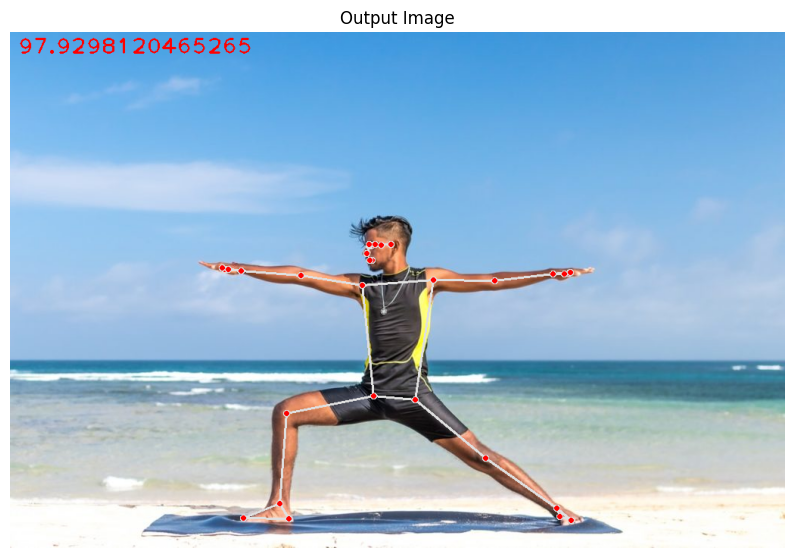

In [66]:
image = cv2.imread('media/warriorIIpose.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    MediaPipeGetAngles(landmarks, output_image, display=True)